In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from dotenv import load_dotenv
import gradio as gr
from IPython.display import display, Image
import requests
import os
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.agents import Tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv(override=True)

True

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
graph_builder = StateGraph(State)

In [5]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})


In [6]:
tool_push = Tool(
    name="send_push_notification",
    func=push,
    description="useful for when you want to send a push notification"
)

In [7]:
# !node --version

In [8]:
# !uv run playwright install

In [9]:
import nest_asyncio
nest_asyncio.apply()

In [10]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

async_browser = create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [13]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Vimal Pillai\AppData\Local\ms-playwright\chromium-1181\chrome-win\chrome.exe> version=139.0.7258.5>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Vimal Pillai\AppData\Local\ms-playwright\chromium-1181\chrome-win\chrome.exe> version=139.0.7258.5>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Vimal Pillai\AppData\Local\ms-playwright\chromium-1181\chrome-win\chrome.exe> version=139.0.7258.5>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Vimal Pillai\AppData\Local\ms-playwright\chromium-1181\chrome-win\chrome.exe> version=139.0.7258.5>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Vimal Pillai\AppData\Local\ms-playwright\chromium-1181\chrome-win\chrome.exe> version=139.0.7258.5>
get_elements=async_b

In [14]:
tool_dict = {tool.name: tool for tool in tools}
navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

In [15]:
await navigate_tool.arun({"url": "https://www.coolermaster.com/en-in/products/masterbox-td500/"})
text = await extract_text_tool.arun({})

In [16]:
import textwrap
print(textwrap.fill(text))

This page doesn’t exist Products Products Products Cooling Cooling
Cooling Air Cooling Liquid Cooling Case Fans Thermal Paste Laptop
Cooling Standard Cooler Phone Cooler view all PC Cases PC Cases PC
Cases Full Tower Mid Tower Mini Tower Mini ITX PC Case Accessories
view all Power Supplies Power Supplies Power Supplies X Series V
Series V SFX Series GX Series MWE Series Elite Series view all
Accessories Accessories Accessories Monitors Keyboard Mice Audio Mouse
pads Controllers view all Furniture Furniture Furniture Chairs Desk
Accessories view all Systems Systems Systems view all MasterHub
MasterHub MasterHub view all MAX MAX MAX ATX Mini ITX view all
Immersive Experience Immersive Experience Immersive Experience view
all Cooling 360 DEGREES OF COOL The next generation AIO liquid cooling
is here with the MasterLiquid 360 Atmos. Discover PC Cases CREATED
ONLY FOR THE BEST HAF 700 EVO unveils a new era of thermal efficiency
through unique features designed to transcend the standards of


In [18]:
all_tools = tools + [tool_push]

In [19]:
llm = ChatOpenAI(model="gpt-4.1-mini")
llm_with_tools = llm.bind_tools(all_tools)

def chatbot(old_state: State):
    return {"messages": [llm_with_tools.invoke(old_state["messages"])]}

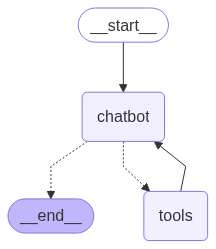

In [21]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools=all_tools))
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role":"user","content":user_input}]},config=config)
    return result["messages"][-1].content

In [23]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
